In [1]:
# We'll start with our library imports...
from __future__ import print_function
import pandas
import seaborn as sn
import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops
from keras.datasets import cifar100
from keras import backend as k 
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Dropout
from functools import partial


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dxdj8iq1 because the default path (/home/cse479/maxnguyen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
(images, labels), (temp, temp1) = cifar100.load_data()
temp = temp /255.0
train_images, validation_images = images[45000:], images[:45000]
train_labels, validation_labels = labels[45000:], labels[:45000]


In [3]:
print(train_labels)

[[85]
 [92]
 [66]
 ...
 [ 3]
 [ 7]
 [73]]


In [4]:
img_rows, img_cols, img_width = 32, 32, 3
  
# if k.image_data_format() == 'channels_first': 
#    train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols, img_width) 
#    validation_images = validation_images.reshape(validation_images.shape[0], 1, img_rows, img_cols, img_width) 
#    inpx = (img_rows, img_cols, img_width)
  
# else: 
#    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_width) 
#    validation_images = validation_images.reshape(validation_images.shape[0], img_rows, img_cols, img_width) 
#    inpx = (img_rows, img_cols, img_width) 
  
train_images = train_images.astype('float32') 
validation_images = validation_images.astype('float32') 
train_images /= 255
validation_images /= 255
temp /= 255

In [5]:
train_labels = keras.utils.to_categorical(train_labels)
print(train_labels.shape)
validation_labels = keras.utils.to_categorical(validation_labels)
temp1 = keras.utils.to_categorical(temp1)

(5000, 100)


In [6]:
input_shape = (img_rows, img_cols, img_width)

In [7]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
        DefaultConv2D(filters, strides=strides),
        keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
            DefaultConv2D(filters, kernel_size=1, strides=strides),
            keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [8]:
class ResBlock(keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super().__init__()
        self.stride = stride

        # Both self.conv1 and self.down_conv layers downsample the input when stride != 1
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            padding="same")

        if self.stride != 1:
            self.down_conv = tf.keras.layers.Conv2D(filters=filter_num,
                                                    kernel_size=(1, 1),
                                                    strides=stride,
                                                    padding="same")
            self.down_bn = tf.keras.layers.BatchNormalization()

    def __call__(self, x, is_training = True):
        identity = x
        if self.stride != 1:
            identity = self.down_conv(identity)
            identity = self.down_bn(identity, training=is_training)

        x = self.bn1(x, training=is_training)
        x = tf.nn.relu(x)
        x = self.conv1(x)
        
        
        x = self.bn2(x, training=is_training)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        return x + identity

In [17]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
input_shape=input_shape))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 2 + [128] * 2 + [256] * 2 + [512] * 2:
    strides = 1 if filters == prev_filters else 2
    model.add(ResBlock(filters, stride=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization_52 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
tf_op_layer_Relu_44 (TensorF [(None, 8, 8, 64)]        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 8, 8, 64)         

In [ ]:
# using Sequential groups all the layers to run at once

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
history = model.fit(train_images, train_labels, batch_size = 32, epochs=100, validation_data=(validation_images, validation_labels), callbacks = [es], shuffle=True, use_multiprocessing=(True))

Epoch 1/100
156/157 [============================>.] - ETA: 0s - loss: 4.9992 - accuracy: 0.0469

In [13]:
model.evaluate(validation_images, validation_labels)


1407/1407 [==============================] - 31s 22ms/step - loss: 5.8013 - accuracy: 0.1885


[5.801265239715576, 0.18853333592414856]

In [14]:
model.evaluate(temp, temp1)

313/313 [==============================] - 27s 87ms/step - loss: 7.3978 - accuracy: 0.0953


[7.397806167602539, 0.09529999643564224]

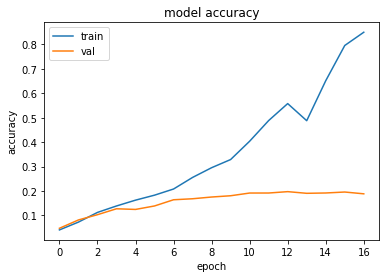

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

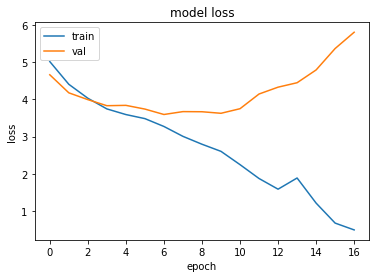

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
tf.saved_model.save(model, 'homework1/cifar100')